In [1]:
import pickle
import SVO
import neo4j
import re
import time
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
from multiprocessing import Process, Queue, Pool 
from tqdm import tqdm 
import boto3
import os
from cathay.config import ApplicationConfig
from cathay.util.SimplePool.threadpool import ThreadPool
from cathay.util.SimplePool.thread_job import ThreadJob

# 讀檔

In [2]:
with open(f"{ApplicationConfig.get_reuters_path()}tesla.pkl", 'rb') as f:
    data = pickle.load(f)

In [3]:
# 整理格式
result = []
data['date'] = data['date'].apply(lambda x:time.strptime(x.split('/')[0], '%B %d, %Y '))
data['date'] = data['date'].apply(lambda x:time.strftime('%Y-%m-%d',x))
result = data.to_dict('records')

In [4]:
date_set = list(set([x['date'] for x in result]))
date_set.sort(reverse=True)
month_set = list(set([x[:7] for x in date_set]))
month_set.sort(reverse=True)
# month_set.pop(-1)

<BarContainer object of 13 artists>

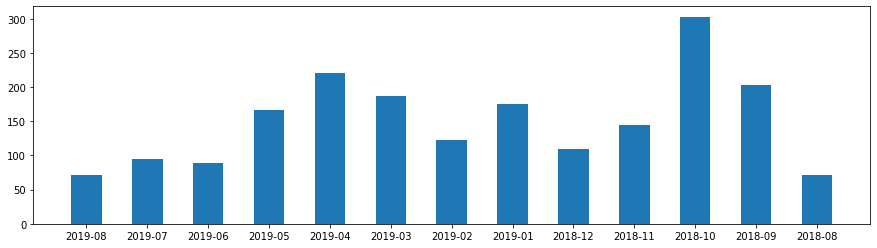

In [5]:
num = []
for i in month_set:
    num.append(len([x for x in result if i in x['date']]))

plt.figure(figsize=(15,4))
plt.bar(month_set, num, width = 0.5)

In [6]:
len(result)

1960

# Find SVO

In [7]:
len(date_set)

258

In [8]:
graph = neo4j.Neo4j_File()
folder = 'Reuters_Tesla_1'
# folder = 'Reuters_Huawei'
graph.Create_Folder(folder, True)

Reuters_Tesla_1 has already existed.


In [9]:
def do(sent, date, new, count, tag):  
#     try:     
        sent = re.sub("[+\!\/_$%^*()-+.:\"\'“”]+|[+——！，。？、~@#￥%……&*（）：`]+", '', sent)
        sent = sent.replace('Headlines', '')
        svo = SVO.SVO(sent)
        svo_result = svo.find_svo()
        if svo_result != 'Sentence can not find SVO.':
            graph.ToFile(svo_result, sent, date, new, count, tag)
        
#     except Exception as e:
#             print(e)

In [10]:
if __name__ == '__main__':
    news_id = []
    sent_pool = []
    t = ThreadPool(12)
    start = time.time()
    source = 'Reuters'
    for date in tqdm(range(len(date_set))):
        sentence = [x for x in result if x['date'] == date_set[date]]

        for i in sentence:
            new = hash(i['title']+i['date'])
            if new not in [x['id'] for x in news_id]:
                news_id.append({'id':new, 'title':i['title']+i['date'], 'text':i['text']})
                sent = [s for s in sent_tokenize(i['text']) if 'Tesla' in s]
                sent = [s for s in sent if s not in sent_pool]
                sent_pool += sent
                count = 0
                
                for j in range(len(sent)): 
                    if j == 0 and '-' in sent[j]:
                        sent[j] = sent[j][sent[j].index('-')+1:]

                    job = ThreadJob(do, (sent[j], i['date'], new, count, source))
                    t.add_job(job)
                    count += 1

    t.start()
    t.finish()  
    end = time.time()
    print(end-start)

100%|██████████| 258/258 [00:00<00:00, 276.05it/s]


103.40716028213501


In [11]:
with open(ApplicationConfig.get_neo4j_svo_output_path()+folder+'/news_id.pkl', 'wb') as f:
    pickle.dump(news_id, f)

# News' Entity

In [12]:
def name_entity(sent, Id, path, comprehend):
    entity = []
    
    for text in sent:
        entity += comprehend.detect_entities(Text=text, LanguageCode='en')['Entities']
        
    with open(path+'/'+str(Id)+'.pkl', 'wb') as f:
        pickle.dump(entity, f)

In [13]:
# name_entity
path = ApplicationConfig.get_neo4j_svo_output_path()+folder+'/name_entity'
if not os.path.isdir(path):
    os.mkdir(path)
    print('Create Successfully')
    
aws_nlu_config =  ApplicationConfig.get_aws_nlu_config()
comprehend = boto3.client(aws_access_key_id=aws_nlu_config['access_key'], aws_secret_access_key=aws_nlu_config['secret_key'], service_name='comprehend', region_name=aws_nlu_config['region'])
t = ThreadPool(4)
start = time.time()
for i in tqdm(news_id):
    sent = [s for s in sent_tokenize(i['text']) if 'Tesla' in s]
#     name_entity(sent, i['id'], path, comprehend)
    job = ThreadJob(name_entity, (sent, i['id'], path, comprehend))
    t.add_job(job)
    
t.start()
t.finish()      
end = time.time()
print(end-start)

100%|██████████| 1050/1050 [00:00<00:00, 1479.03it/s]


221.61590003967285


In [2]:
# 資料夾內的Node Integrate
# Add Entity
folder = 'Reuters_Tesla_1'
neo4j.Save(folder)

/home/nlp/s3/Financial_News_Extraction/src/cathay/re/neo4j.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['token'] = tmp.apply(lambda x: nltk.word_tokenize(x['start']+x['end']), axis = 1)


Training word2vec model...
Finished!


# 匯入Neo4j

In [3]:
load = neo4j.Csv2Neo4j()

In [4]:
folder = 'Reuters_Tesla'
# import Node
load.Load(folder)
# import Relation
load.Load(folder, False)

# SNA指標

In [ ]:
graph = neo4j.SNA_Indicator(1)

In [ ]:
degree_centrality = graph.Centrality('Degree')
graph.Plot(degree_centrality.iloc[1:6], 'Degree Centrality')

degree_centrality = graph.Centrality('Degree', False)
degree_centrality = degree_centrality.sort_values('2019-07-31', ascending = False)
graph.Plot(degree_centrality.iloc[1:6], 'Degree Centrality')

In [ ]:
degree_centrality = graph.Centrality('Betweeness')
graph.Plot(degree_centrality.iloc[1:6], 'Betweeness Centrality')

degree_centrality = graph.Centrality('Betweeness', False)
degree_centrality = degree_centrality.sort_values('2019-07-31', ascending = False)
graph.Plot(degree_centrality.iloc[1:6], 'Betweeness Centrality')

In [ ]:
degree_centrality = graph.Centrality('Closeness')
graph.Plot(degree_centrality.iloc[1:6], 'Closeness Centrality')

degree_centrality = graph.Centrality('Closeness', False)
degree_centrality = degree_centrality.sort_values('2019-07-31', ascending = False)
graph.Plot(degree_centrality.iloc[1:6], 'Closeness Centrality')

In [ ]:
degree_centrality = graph.Centrality('PageRank')
graph.Plot(degree_centrality.iloc[1:6], 'PageRank Centrality')

degree_centrality = graph.Centrality('PageRank', False)
degree_centrality = degree_centrality.sort_values('2019-07-31', ascending = False)
graph.Plot(degree_centrality.iloc[1:6], 'PageRank Centrality')

In [ ]:
graph.Plot(degree_centrality.iloc[1:10], 'PageRank Centrality')

In [ ]:
degree_centrality.sort_values('2019-07-31', ascending = False)

# Stock Price

In [ ]:
price = graph.Load_data('dataset/us_stock_prices/FinancialData/TSLA/TSLA_history_prices_daily.csv', '2019-06-01')

In [ ]:
graph.Plot(price, 'Stock Price')

# Create NetworkX from csv file

In [18]:
from cathay.config import ApplicationConfig
import pandas as pd
import networkx as nx
path = ApplicationConfig.get_neo4j_svo_output_path() + 'Reuters_Tesla'

In [16]:
rel = pd.read_csv(path+'/Relation_revise.csv')
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(rel, 'start', 'end', create_using = Graphtype)

# Train Node2Vec

In [47]:
from node2vec import Node2Vec
node2vec = Node2Vec(G, dimensions=128, walk_length=3, num_walks=200, workers=4)
model = node2vec.fit(window=3, min_count=1, batch_words=4)
# model.save('node2vec_model')

Computing transition probabilities: 100%|██████████| 9882/9882 [00:11<00:00, 895.29it/s] 


In [3]:
model.most_similar('tesla')

NameError: name 'model' is not defined

In [ ]:
model.wv.most_similar('10') 

In [ ]:
model.save('node2vec_model')

In [6]:
from py2neo import Node, Relationship, Graph
graph = Graph("http://13.112.207.201:7474/browser", user = 'neo4j', password = 'neo4j@cathay')
graph.delete_all()